In [1]:
# Pytorch CNN walkthrough

In [48]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import pandas as pd

In [12]:
def get_data():
    data_dir = '/Users/henryfriesen/LHL_projects/Capstone/C-NMC_Leukemia/training_data/'
   
    transform = transforms.Compose([
        #transforms.RandomRotation(20),
        transforms.RandomResizedCrop(128),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

    train_set = datasets.ImageFolder(data_dir + '/fold_0', transform=transform)
    test_set = datasets.ImageFolder(data_dir + '/fold_1', transform=transform)

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size=32, shuffle=True)

    return train, test


In [13]:
train, test = get_data()

In [28]:
print(len(train))

111


In [36]:
def train_imshow():
    classes = ('all', 'hem') # Defining the classes we have
    dataiter = iter(train)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(figsize=(12, 6), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()


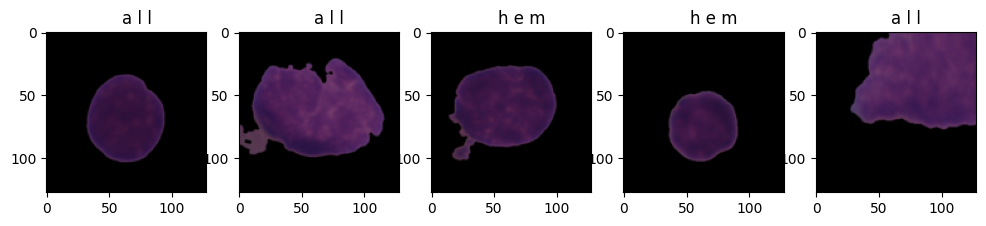

In [37]:
train_imshow()

In [88]:
import torchvision.models as models

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [90]:
# net = Net()
model = models.efficientnet_b3(pretrained=True)

print(model)

model.classifier = nn.Sequential(
    nn.Linear(in_features=1536, out_features=2),
    nn.Softmax()
)

/Users/henryfriesen/opt/anaconda3/envs/THE_ONE/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/henryfriesen/opt/anaconda3/envs/THE_ONE/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
if torch.cuda.is_available(): # Checking if we can use GPU
    model = net.cuda()
    criterion = criterion.cuda()

losses = []
def train_net(n_epoch):
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        running_n = 0
        running_acc = 0.0
        for i, data in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_n += len(outputs)

            labels_pred = np.argmax(outputs.cpu().detach().numpy(),axis=1)
            # print(outputs)
            # print(labels)
            # print(labels_pred)
            # print(loss)

            # acc = np.sum(((outputs.cpu().detach().numpy()[:,0] > 0.5) == labels.numpy()))/batch_size
            acc = np.sum(labels_pred == labels.detach().numpy())

            # print statistics
            losses.append(loss.item())
            running_loss += len(outputs)*loss.item()
            running_acc += acc
            # if i % 10 == 0:  # print every 2000 mini-batches
                # print('[%d, %5d] loss: %.10f | accuracy: %.5f' %
                    #   (epoch + 1, i + 1, running_loss / running_n, 100*acc))
        print(f'epoch: {epoch:04d} | loss = {running_loss/running_n:0.8f} | accuracy = {100*running_acc/running_n:0.1f}')
# plt.plot(losses, label='Training loss')
# plt.show()
# print('Finished Training')

In [92]:
new_var = train_net(100)

epoch: 0000 | loss = 0.42808676 | accuracy = 80.6
epoch: 0001 | loss = 0.43029944 | accuracy = 79.9
epoch: 0002 | loss = 0.43530844 | accuracy = 79.5
epoch: 0003 | loss = 0.43278443 | accuracy = 79.8
epoch: 0004 | loss = 0.42383484 | accuracy = 80.3
epoch: 0005 | loss = 0.43931241 | accuracy = 78.0
epoch: 0006 | loss = 0.42173346 | accuracy = 80.0
epoch: 0007 | loss = 0.43384789 | accuracy = 79.2
epoch: 0008 | loss = 0.44296952 | accuracy = 79.1
epoch: 0009 | loss = 0.43566127 | accuracy = 79.1
epoch: 0010 | loss = 0.43048566 | accuracy = 79.4
epoch: 0011 | loss = 0.44349107 | accuracy = 78.5
epoch: 0012 | loss = 0.43434197 | accuracy = 79.4
epoch: 0013 | loss = 0.43532929 | accuracy = 80.3
epoch: 0014 | loss = 0.43343351 | accuracy = 79.6
epoch: 0015 | loss = 0.43165212 | accuracy = 79.8
epoch: 0016 | loss = 0.44159722 | accuracy = 79.1
epoch: 0017 | loss = 0.43613296 | accuracy = 79.4
epoch: 0018 | loss = 0.44007885 | accuracy = 79.1
epoch: 0019 | loss = 0.43930347 | accuracy = 79.5


In [93]:
print(losses)

[0.43200787901878357, 0.4528353810310364, 0.4176308512687683, 0.4264967441558838, 0.3962042033672333, 0.41419893503189087, 0.37830018997192383, 0.37464869022369385, 0.49954476952552795, 0.44573354721069336, 0.64908367395401, 0.252226859331131, 0.5895732641220093, 0.4857759475708008, 0.5818734765052795, 0.4135272204875946, 0.421977162361145, 0.3393354117870331, 0.5048733353614807, 0.34426605701446533, 0.5236265063285828, 0.3245483636856079, 0.4195534884929657, 0.36390817165374756, 0.49131298065185547, 0.3151908218860626, 0.38259926438331604, 0.273329496383667, 0.4070679247379303, 0.42696690559387207, 0.3834937810897827, 0.5129476189613342, 0.2583889067173004, 0.4047203063964844, 0.4180234670639038, 0.44375306367874146, 0.45865559577941895, 0.47133082151412964, 0.38579630851745605, 0.4786824882030487, 0.6116917729377747, 0.3583674728870392, 0.32085004448890686, 0.2973710596561432, 0.5172255039215088, 0.3370550274848938, 0.4435872733592987, 0.33234360814094543, 0.36043286323547363, 0.3183

In [ ]:
# note for troubleshooting: added .detach() to plot line:
# plt.plot(losses, label='Training loss')

# attempt to avoid error:
# runtimeerror: can't call numpy() on tensor that requires grad. use tensor.detach().numpy() instead.

# new additional error:
# AttributeError: 'list' object has no attribute 'detach'


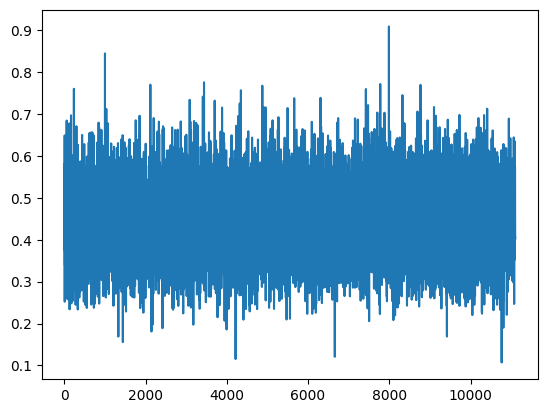

In [94]:
fig, ax = plt.subplots()
ax.plot(losses)
plt.show()


In [95]:
#PATH = './cat_dog_net.pth'
# torch.save(net.state_dict(), PATH)

# Loading the trained network
# net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
with torch.no_grad():
    for data in test:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(test),
    100 * correct / total))

Accuracy of the network on the 112 test images: 77 %
